In [1]:
#imports for when I need quickReco
import numpy as np
from matplotlib import pyplot as plt
from quickRecoNew import quickReco
import math

In [2]:
def calculate_significance(signal, background, cut_value):
    sig_below=0.0 
    sig_above=0.0
    signal_count_below=0.0
    background_count_below = 0.0
    signal_count_above = 0.0
    background_count_above = 0.0
    
    
    signal_length = len(signal)
    background_length=len(background)
    
    for i in range(signal_length):
        if signal[i]<cut_value:
            signal_count_below=signal_count_below+1.0;
        if signal[i]>cut_value:
            signal_count_above=signal_count_above+1.0;

    for i in range(background_length):
        if background[i]<cut_value:
            background_count_below=background_count_below+1.0;
        if background[i]>cut_value:
            background_count_above=background_count_above+1.0;
     
    if signal_count_below < 10.0:
        sig_below = 0.0
    elif background_count_below < 10.0:
        sig_below = 0.0
    else:
        sig_below = (signal_count_below/math.sqrt((background_count_below)))
    if signal_count_above < 10.0:
        sig_above = 0.0
    elif background_count_above < 10.0:
        sig_above = 0.0
    else:
        sig_above = (signal_count_above/math.sqrt((background_count_above)))    
    return(sig_below, sig_above);


In [3]:
def calculate_bounds(signal,background):
    sig_low = 2000000000000000000000.0;#highest value a double can have if this was C. I just picked a really big number
    back_low = 2000000000000000000000.0;#highest value a double can have
    sig_high = -2000000000000000000000.0; #lowest value a double can have
    back_high = -2000000000000000000000.0; #lowest value a double can have
    
    signal_length = len(signal)
    background_length=len(background)
    
    for i in range(signal_length):
        if signal[i]<sig_low:
            sig_low = signal[i]
        elif signal[i]>sig_high:
            sig_high = signal[i]
        else:
            continue

    for i in range(background_length):
        if background[i]<back_low:
            back_low = background[i]
        elif background[i]>back_high:
            back_high=background[i]
        else:
            continue    

    highest=0.0
    lowest =0.0
    
    if sig_high < back_high:
        highest=sig_high
    else :
        highest=back_high
    
    if sig_low > back_low:
        lowest=sig_low;
    else:
        lowest=back_low
    
    return(lowest, highest)

In [4]:
def calculate_increment(lower, upper, nsteps):
    return((upper-lower)/(nsteps))

In [5]:
def calculate_best_cut(signal, background):
    
    if list_in_list_check(signal) and list_in_list_check(background):
        signal_dummy_list = []
        for i,arr in enumerate (signal):
            for j,value in enumerate(arr):
                signal_dummy_list.append(value)
        background_dummy_list = []
        for i, arr in enumerate (background):
            for j, value in enumerate(arr):
                background_dummy_list.append(value)
                
        return(calculate_best_cut(signal_dummy_list, background_dummy_list))
                
    elif not (list_in_list_check(signal) and list_in_list_check(background)):   
        upper = 0.0
        lower = 0.0
        lower, upper = calculate_bounds(signal, background)
    
        nsteps = 100.0 #insert value here
        increment = calculate_increment (lower, upper, nsteps)
    
        cut = lower +(0.5*increment)
    
        best_cut = 0.0 
        best_significance=0.0
        direction = 'empty'
    
        while cut<upper:
            significance_below, significance_above = calculate_significance(signal, background, cut)
            if significance_below > best_significance:
                best_significance = significance_below
                best_cut=cut
                direction = 'below'
            if significance_above > best_significance:
                best_significance = significance_above
                best_cut = cut
                direction = 'above'
            cut=cut + increment
        return(best_cut, best_significance, direction)
    else:
        print('Mismatch between list type of signal and list type of background input')
        return('error','error','error')

In [6]:
def removal_check(value, direction, cut):
    if direction == 'above':
        if value < cut:
            return(True)
        if value > cut:
            return(False)
    elif direction =='below':
        if value > cut:
            return(True)
        if value < cut:
            return(False)
    else:
        return(None)

In [7]:
def list_in_list_check(name):
    return(any(isinstance(el,list)for el in name))
#True means it is a list which contains lists.
#False means it is a normal list

In [8]:
def make_index_delete_list(data, direction, cut):
    indicies = []
    
    if list_in_list_check(data):
        appendable = []
        for i, array in enumerate(data):
            for j, value in enumerate(array):
                if j == 0:
                    first = True
                if removal_check(value, direction, cut):
                    if not first:
                        appendable.append(j)
                    if first:
                        appendable.append(i)
                        appendable.append(j)
                        first = False
            if appendable == []:
                continue
            else:
                appendable.append(j+1)
                indicies.append(appendable)
            appendable = []
        indicies.sort(reverse=True)
        return (indicies)
    
    if not list_in_list_check(data):
        for i,value in enumerate(data):
            if removal_check(value,direction,cut):
                indicies.append(i)
        indicies.sort(reverse=True)
        return(indicies)

In [9]:
def delete_cut_data(indicies, data_to_cut):
    if not list_in_list_check(indicies):
        for i in range(len(indicies)):
            del data_to_cut[indicies[i]]
        return(data_to_cut)
    if list_in_list_check(indicies):
        if not list_in_list_check(data_to_cut):
            for i, array in enumerate(indicies):
                nvalues=len(array)-2
                if nvalues == array[-1]:
                    del data_to_cut[array[0]]
            return(data_to_cut)
        if list_in_list_check(data_to_cut):
            for i, indicies_array in enumerate(indicies):
                nvalues = len(indicies_array)-2
                if nvalues==indicies_array[-1]:
                    del data_to_cut[indicies_array[0]]
                else:
                    dummy_array = []
                    dummy_array = indicies_array
                    del dummy_array[0]
                    del dummy_array[-1]
                    dummy_array.sort(reverse=True)
                    for j, index in enumerate(dummy_array):
                        del data_to_cut[indicies_array[0]][index]
            return(data_to_cut)

In [10]:
signal = quickReco('signal','\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\DM_first_model_first_run\\ppTOllxdxd_signal\\seed_10_xdxd_delphes_events.root')
background = quickReco('background','\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\DM_first_model_first_run\\ppTOll background')

In [11]:
signal.process()


...Loading file 
\Users\student\Desktop\College\Summer_2020\Research\DM_first_model_first_run\ppTOllxdxd_signal\seed_10_xdxd_delphes_events.root
...Finished loading branches
Processed 0 events...


IndexError: list index out of range

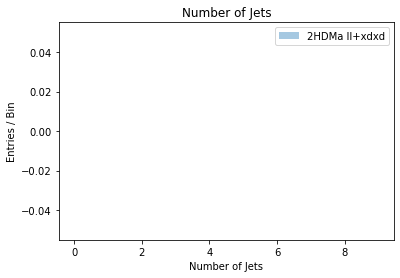

In [88]:
plt.hist(signal.dilepton_missingET, bins=np.arange(0,10), alpha=0.4, label='2HDMa ll+xdxd')
plt.title('Number of Jets')
plt.xlabel('Number of Jets')
plt.ylabel('Entries / Bin')
plt.legend()
plt.show()

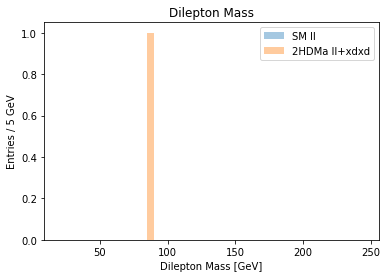

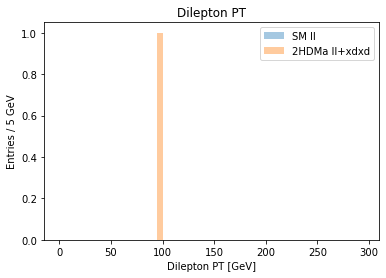

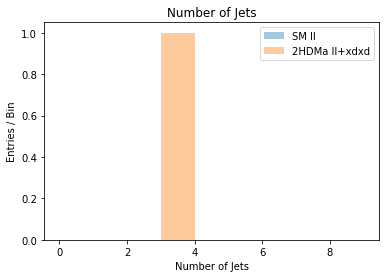

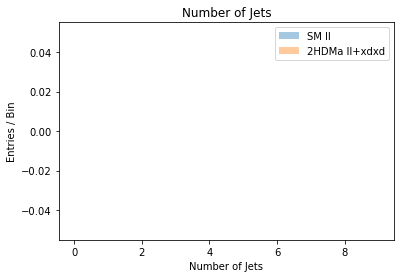

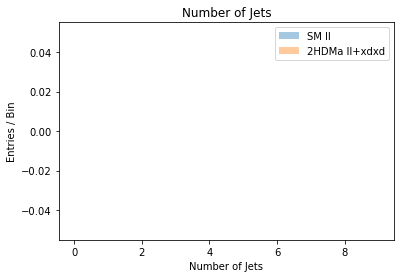

In [43]:
plt.hist(background.dileptonMass, bins=np.arange(20,250,5), alpha=0.4, label='SM ll')
plt.hist(signal.dileptonMass, bins=np.arange(20,250,5), alpha=0.4, label='2HDMa ll+xdxd')
plt.title('Dilepton Mass')
plt.xlabel('Dilepton Mass [GeV]')
plt.ylabel('Entries / 5 GeV')
plt.legend()
plt.show()

plt.hist(background.dileptonPT, bins=np.arange(0,300,5), alpha=0.4, label='SM ll')
plt.hist(signal.dileptonPT, bins=np.arange(0,300,5), alpha=0.4, label='2HDMa ll+xdxd')
plt.title('Dilepton PT')
plt.xlabel('Dilepton PT [GeV]')
plt.ylabel('Entries / 5 GeV')
plt.legend()
plt.show()

plt.hist(background.dilepton_Jets, bins=np.arange(0,10), alpha=0.4, label='SM ll')
plt.hist(signal.dilepton_Jets, bins=np.arange(0,10), alpha=0.4, label='2HDMa ll+xdxd')
plt.title('Number of Jets')
plt.xlabel('Number of Jets')
plt.ylabel('Entries / Bin')
plt.legend()
plt.show()

plt.hist(background.dilepton_MET, bins=np.arange(0,10), alpha=0.4, label='SM ll')
plt.hist(signal.dilepton_MET, bins=np.arange(0,10), alpha=0.4, label='2HDMa ll+xdxd')
plt.title('Number of Jets')
plt.xlabel('Number of Jets')
plt.ylabel('Entries / Bin')
plt.legend()
plt.show()

plt.hist(background.dilepton_HT, bins=np.arange(0,10), alpha=0.4, label='SM ll')
plt.hist(signal.dilepton_HT, bins=np.arange(0,10), alpha=0.4, label='2HDMa ll+xdxd')
plt.title('Number of Jets')
plt.xlabel('Number of Jets')
plt.ylabel('Entries / Bin')
plt.legend()
plt.show()

In [ ]:
#Test
#list all of the variables that are being cut on here:
#.dileptonMass
#.dileptonPT
#.nJets
#

data1_sig = signal.dileptonMass
data1_back = background.dileptonMass
data2_sig = signal.dileptonPT
data2_back = background.dileptonPT
data3_sig = signal.dilepton_Jets
data3_back = background.dilepton_Jets

data1_cut, data1_significance, data1_direction = calculate_best_cut(data1_sig, data1_back)
print(data1_cut, data1_significance, data1_direction)
data2_cut, data2_significance, data2_direction = calculate_best_cut(data2_sig, data2_back)
print(data2_cut, data2_significance, data2_direction)
data3_cut, data3_significance, data3_direction = calculate_best_cut(data3_sig, data3_back)
print(data3_cut, data3_significance, data3_direction)

significance_list = [data1_significance, data2_significance, data3_significance]

cut1_max_significance = max(significance_list)



In [61]:
if cut1_max_significance == data1_significance:
    print("cut one was made on data1")
    cut1_cut = data1_cut
    cut1_direction = data1_direction
    
    indicies_sig_cut1 = make_index_delete_list(data1_sig, cut1_direction, cut1_cut)
    cut1_data1_sig = delete_cut_data(indicies_sig_cut1, data1_sig)
    cut1_data2_sig = delete_cut_data(indicies_sig_cut1, data2_sig)
    cut1_data3_sig = delete_cut_data(indicies_sig_cut1, data3_sig)
    
    indicies_back_cut1 = make_index_delete_list(data1_back, cut1_direction, cut1_cut)
    cut1_data1_back = delete_cut_data(indicies_back_cut1, data1_back)
    cut1_data2_back = delete_cut_data(indicies_back_cut1, data2_back)
    cut1_data3_back = delete_cut_data(indicies_back_cut1, data3_back)
    
elif cut1_max_significance == data2_significance:
    print("cut one was made on data2")
    cut1_cut = data2_cut
    cut1_direction = data2_direction
    
    indicies_sig_cut1 = make_index_delete_list(data2_sig, cut1_direction, cut1_cut)
    cut1_data1_sig = delete_cut_data(indicies_sig_cut1, data1_sig)
    cut1_data2_sig = delete_cut_data(indicies_sig_cut1, data2_sig)
    cut1_data3_sig = delete_cut_data(indicies_sig_cut1, data3_sig)
    
    indicies_back_cut1 = make_index_delete_list(data2_back, cut1_direction, cut1_cut)
    cut1_data1_back = delete_cut_data(indicies_back_cut1, data1_back)
    cut1_data2_back = delete_cut_data(indicies_back_cut1, data2_back)
    cut1_data3_back = delete_cut_data(indicies_back_cut1, data3_back)

elif cut1_max_significance == data3_significance:
    print("cut one was made on data3")
    cut1_cut = data3_cut
    cut1_direction = data3_direction
    
    indicies_sig_cut1 = make_index_delete_list(data3_sig, cut1_direction, cut1_cut)
    cut1_data1_sig = delete_cut_data(indicies_sig_cut1, data1_sig)
    cut1_data2_sig = delete_cut_data(indicies_sig_cut1, data2_sig)
    cut1_data3_sig = delete_cut_data(indicies_sig_cut1, data3_sig)
    
    indicies_back_cut1 = make_index_delete_list(data3_back, cut1_direction, cut1_cut)
    cut1_data1_back = delete_cut_data(indicies_back_cut1, data1_back)
    cut1_data2_back = delete_cut_data(indicies_back_cut1, data2_back)
    cut1_data3_back = delete_cut_data(indicies_back_cut1, data3_back)
else:
    print("An error has occured during Cut 1. No match for the max significance value could be found.")

cut one was made on data2


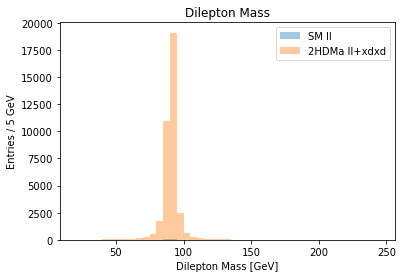

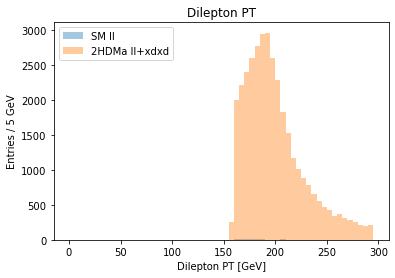

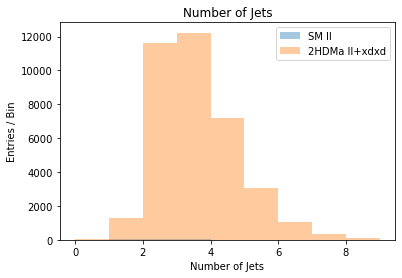

In [63]:
plt.hist(cut1_data1_back, bins=np.arange(20,250,5), alpha=0.4, label='SM ll')
plt.hist(cut1_data1_sig, bins=np.arange(20,250,5), alpha=0.4, label='2HDMa ll+xdxd')
plt.title('Dilepton Mass')
plt.xlabel('Dilepton Mass [GeV]')
plt.ylabel('Entries / 5 GeV')
plt.legend()
plt.show()

plt.hist(cut1_data2_back, bins=np.arange(0,300,5), alpha=0.4, label='SM ll')
plt.hist(cut1_data2_sig, bins=np.arange(0,300,5), alpha=0.4, label='2HDMa ll+xdxd')
plt.title('Dilepton PT')
plt.xlabel('Dilepton PT [GeV]')
plt.ylabel('Entries / 5 GeV')
plt.legend()
plt.show()

plt.hist(cut1_data3_back, bins=np.arange(0,10), alpha=0.4, label='SM ll')
plt.hist(cut1_data3_sig, bins=np.arange(0,10), alpha=0.4, label='2HDMa ll+xdxd')
plt.title('Number of Jets')
plt.xlabel('Number of Jets')
plt.ylabel('Entries / Bin')
plt.legend()
plt.show()